In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import os


In [2]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.fillna(0, inplace=True)
    return agg


In [3]:
# Load and preprocess the data
file_path = "/home/shreevidyag/workspace/Data_bengaluru/combined_cleaned.csv"
data = pd.read_csv(file_path)
data.head()
data.loc[:, 'PM25'] = data['PM25'].fillna(0)
data = data[24:]
data.to_csv('pollution1.csv')
dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
reframed = series_to_supervised(values, 1, 1, True)
reframed.drop(reframed.columns[9:16], axis=1, inplace=True)


In [4]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(reframed.values[:, :-1])
scaled_label = scaler.fit_transform(reframed.values[:, -1].reshape(-1, 1))
values = np.column_stack((scaled_features, scaled_label))


In [5]:
n_train_hours = 60000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])


In [6]:
# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=72, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=72, shuffle=False)


In [7]:
# Define the model
class BiLSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMAttentionModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 50),
            nn.Tanh(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        output = self.fc(context_vector)
        return output

In [8]:
# Initialize model, loss, and optimizer
input_dim = train_X.shape[2]
hidden_dim = 128
output_dim = 1

model = BiLSTMAttentionModel(input_dim, hidden_dim, output_dim)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [9]:
# Save and load model functions
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, input_dim, hidden_dim, output_dim):
    model =  BiLSTMAttentionModel(input_dim, hidden_dim, output_dim)
    model.load_state_dict(torch.load(filepath))
    print(f"Model loaded from {filepath}")
    return model

model_filepath = 'Bilstm_model.pth'

In [10]:
# Check if model exists
model_path = "bilstm_attention_model.pth"
if os.path.exists(model_path):
    print("Loading saved model...")
    model.load_state_dict(torch.load(model_path))
else:
    print("Training new model...")
    # Training loop
    num_epochs = 100
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X).squeeze()
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X).squeeze()
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Test Loss: {val_loss / len(test_loader):.4f}")

    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds")
    # Save the trained model
    torch.save(model.state_dict(), model_path)


Loading saved model...


/tmp/ipykernel_8709/3506258938.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [11]:
# Evaluate the model
model.eval()
yhat = []
true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X).squeeze()
        yhat.extend(predictions.numpy())
        true.extend(batch_y.numpy())


In [12]:
#Reshape test_X to 2D
test_X_2d = test_X.reshape(test_X.shape[0], -1)  # Collapse to (n_samples, n_features)


In [13]:
# Rescale predictions and actual values
yhat = np.array(yhat).reshape(-1, 1)
true = np.array(true).reshape(-1, 1)

inv_yhat = scaler.inverse_transform(np.concatenate([yhat, test_X_2d[:, 1:]], axis=1))[:, 0]
inv_y = scaler.inverse_transform(np.concatenate([true, test_X_2d[:, 1:]], axis=1))[:, 0]


In [14]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print(f"Test RMSE: {rmse:.3f}")

# Calculate R^2
r2 = r2_score(inv_y, inv_yhat)
print(f'Variance score: {r2:.2f}')


Test RMSE: 8.762
Variance score: 0.85


In [15]:
# Pearson correlation
corr, _ = pearsonr(inv_y, inv_yhat)
print(f'Pearson correlation: {corr:.3f}')

Pearson correlation: 0.933


<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_8709/3994989181.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('PM2.5 Concentration $(\mu g / m^3)$')


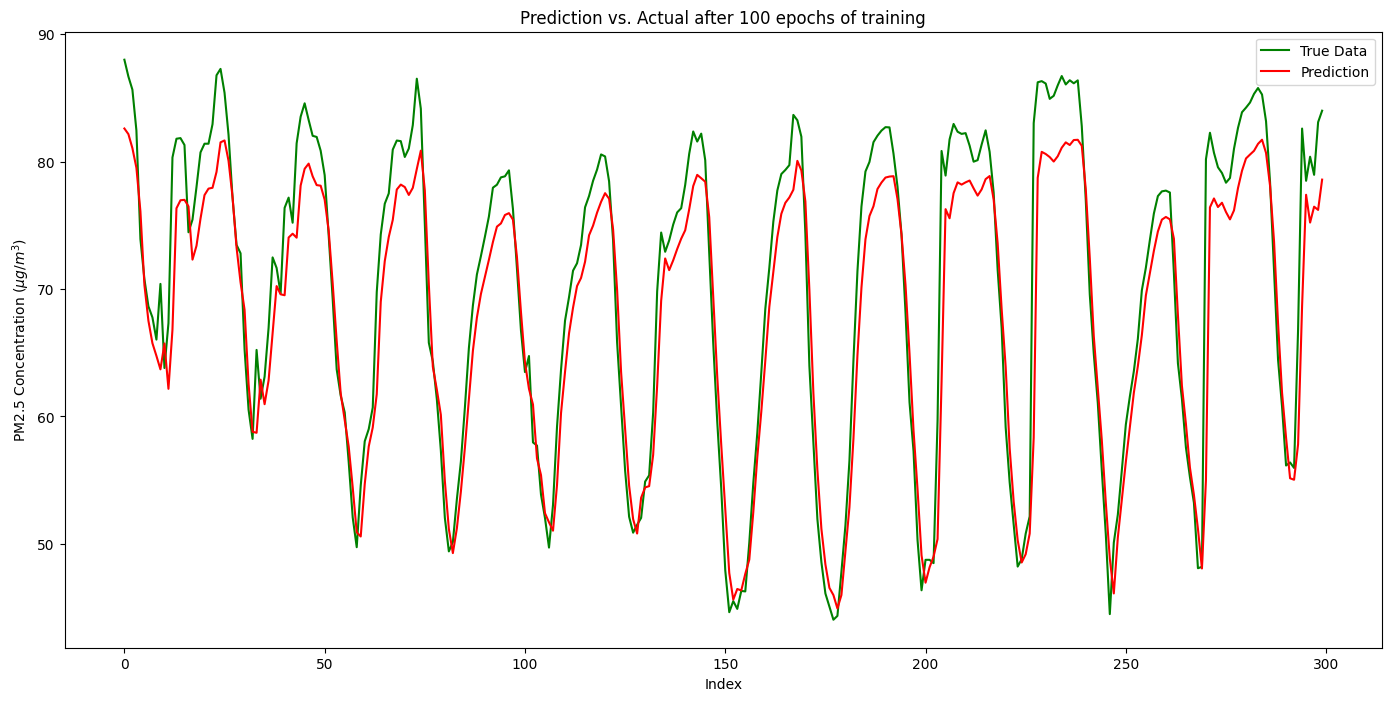

In [16]:
# Plot results
def plot_predicted(predicted_data, true_data):
    plt.figure(figsize=(17, 8))
    plt.title('Prediction vs. Actual after 100 epochs of training')
    plt.plot(true_data, label='True Data', color='green')
    plt.plot(predicted_data, label='Prediction', color='red')
    plt.xlabel('Index')
    plt.ylabel('PM2.5 Concentration $(\mu g / m^3)$')
    plt.legend()
    plt.savefig("bilstm_att_regularizer_pytorch.pdf")
    plt.show()

plot_predicted(inv_yhat[424:724], inv_y[424:724])
